# Variable density values
Here we will extend the `simple_inversion.ipynb` example by using variable density contrast values. We create a map of density contrast values, and supply that instead of the constant density contrast value. This is useful for situations where you know the density contrast across your topographic layer is interest is variable, such as modelled the sediment-basement contact where the basement density changes regionally. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import inversion, plotting, synthetic, utils

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

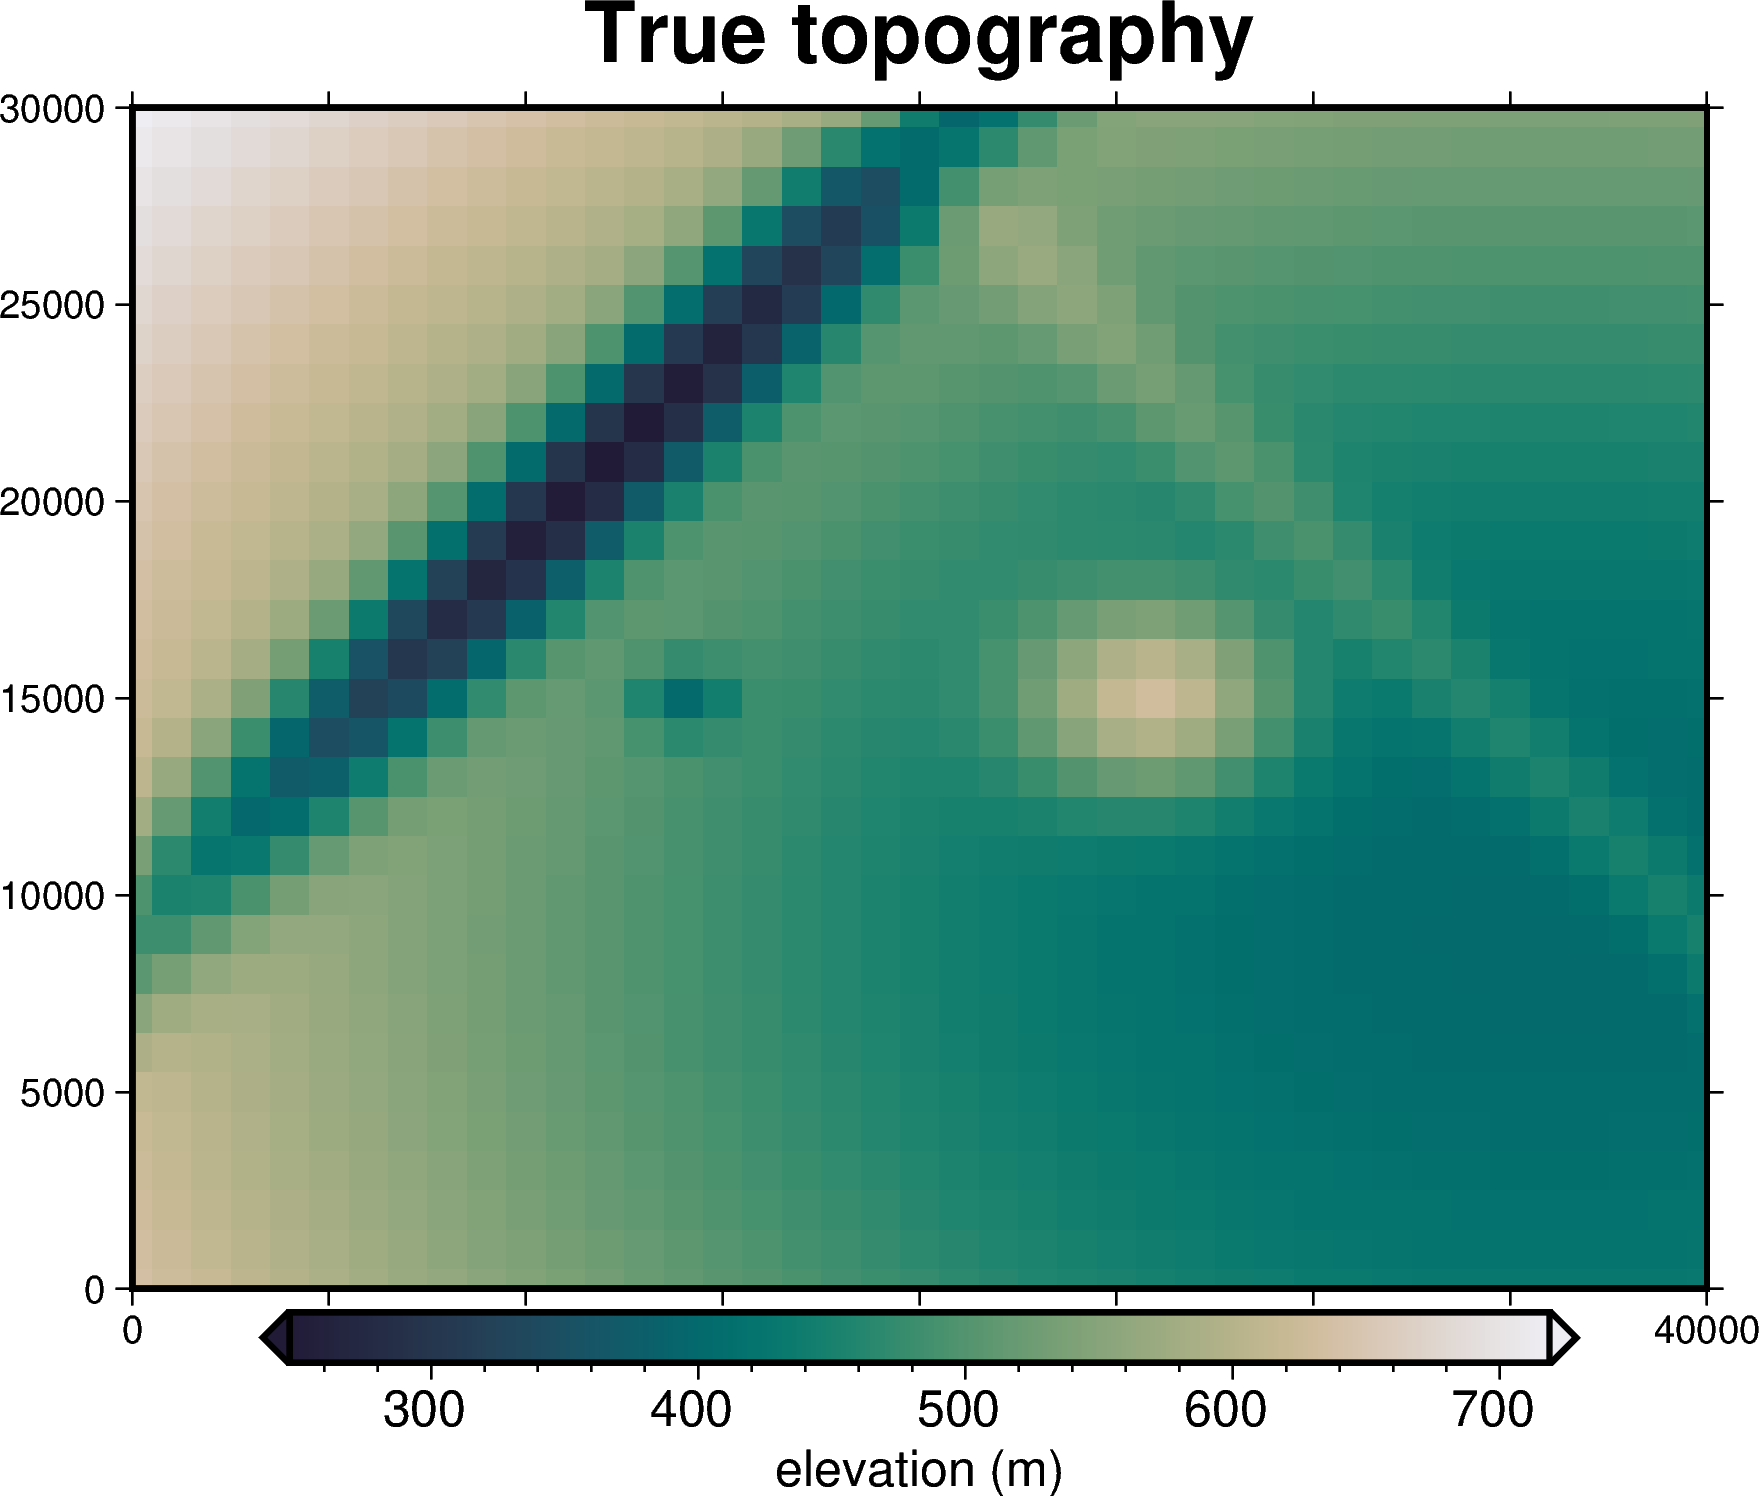

<xarray.DataArray 'upward' (northing: 31, easting: 41)> Size: 10kB
array([[637.12943453, 627.28784729, 617.55840384, ..., 428.39025144,
        429.33158321, 430.64751872],
       [632.95724141, 623.04617819, 613.24496334, ..., 422.67589466,
        423.6241977 , 424.94987872],
       [629.2139621 , 619.27333357, 609.41212904, ..., 417.59868139,
        418.55317844, 419.88752006],
       ...,
       [701.54094486, 692.82534357, 684.20926165, ..., 516.68829114,
        517.52190298, 518.68725132],
       [709.90739328, 701.33808009, 692.86661587, ..., 528.15742206,
        528.97704204, 530.12283044],
       [718.55151946, 710.13334959, 701.81130286, ..., 540.00720706,
        540.8123708 , 541.93795008]])
Coordinates:
  * easting   (easting) float64 328B 0.0 1e+03 2e+03 ... 3.8e+04 3.9e+04 4e+04
  * northing  (northing) float64 248B 0.0 1e+03 2e+03 ... 2.8e+04 2.9e+04 3e+04

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

# plot the true topography
fig = maps.plot_grd(
    true_topography,
    fig_height=10,
    title="True topography",
    cmap="rain",
    reverse_cpt=True,
    grd2_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

true_topography

### Density distribution

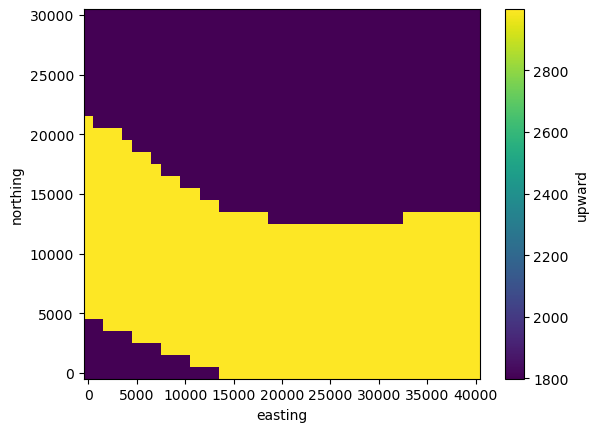

In [3]:
# create some random synthetic data
synthetic_data = synthetic.synthetic_topography_regional(
    spacing,
    region,
    yoffset=20,
)

# the first density contrast is between sediment (~2300 kg/m3) and air (~1 kg/m3)
density_contrast_1 = 1800 - 1

# the second density contrast is between crystalline basement (~2800 kg/m3) and air
# (~1 kg/m3)
density_contrast_2 = 3000 - 1

# use it to create a surface density distribution
density_dist = xr.where(synthetic_data > 0, density_contrast_1, density_contrast_2)

density_dist.plot()

### Prism layer

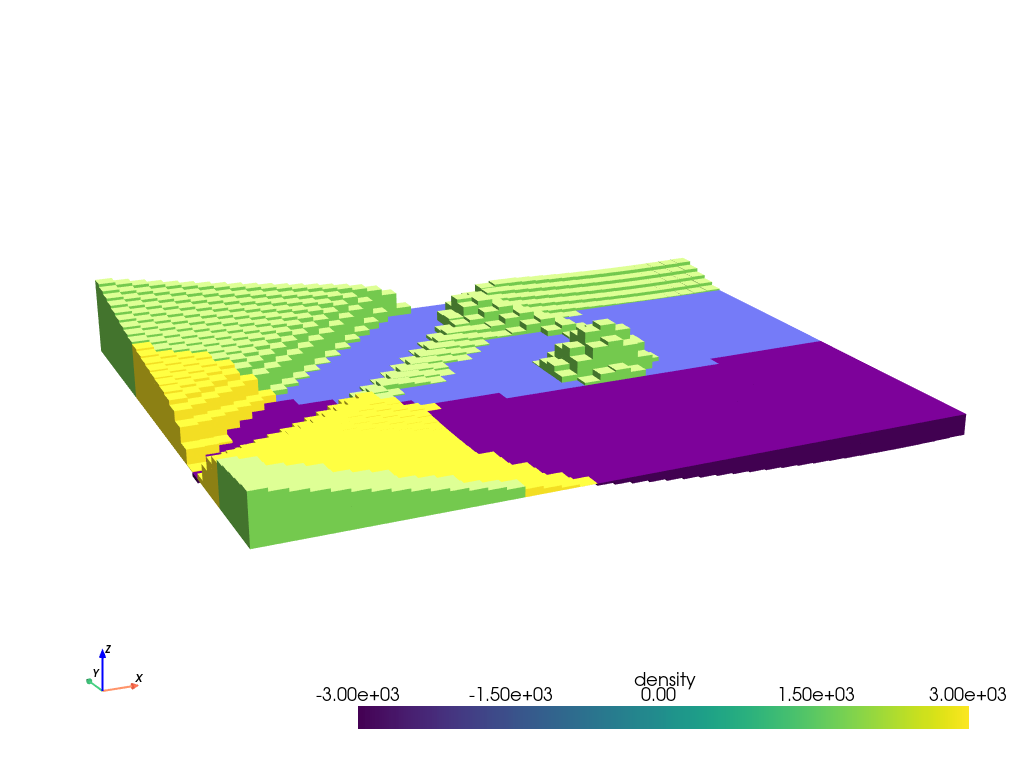

mean topography is 492.2704164812973 m


In [4]:
# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
# density contrast values come from above density distribution
density_grid = xr.where(true_topography >= zref, density_dist, -density_dist)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

print(f"mean topography is {zref} m")

### Forward gravity of prism layer

In [5]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,6.474723
1,0.0,1000.0,1000.0,7.084438
2,0.0,2000.0,1000.0,6.777225
3,0.0,3000.0,1000.0,6.330090
4,0.0,4000.0,1000.0,5.845346
...,...,...,...,...
1266,30000.0,36000.0,1000.0,2.240245
1267,30000.0,37000.0,1000.0,2.238745
1268,30000.0,38000.0,1000.0,2.242352
1269,30000.0,39000.0,1000.0,2.219123


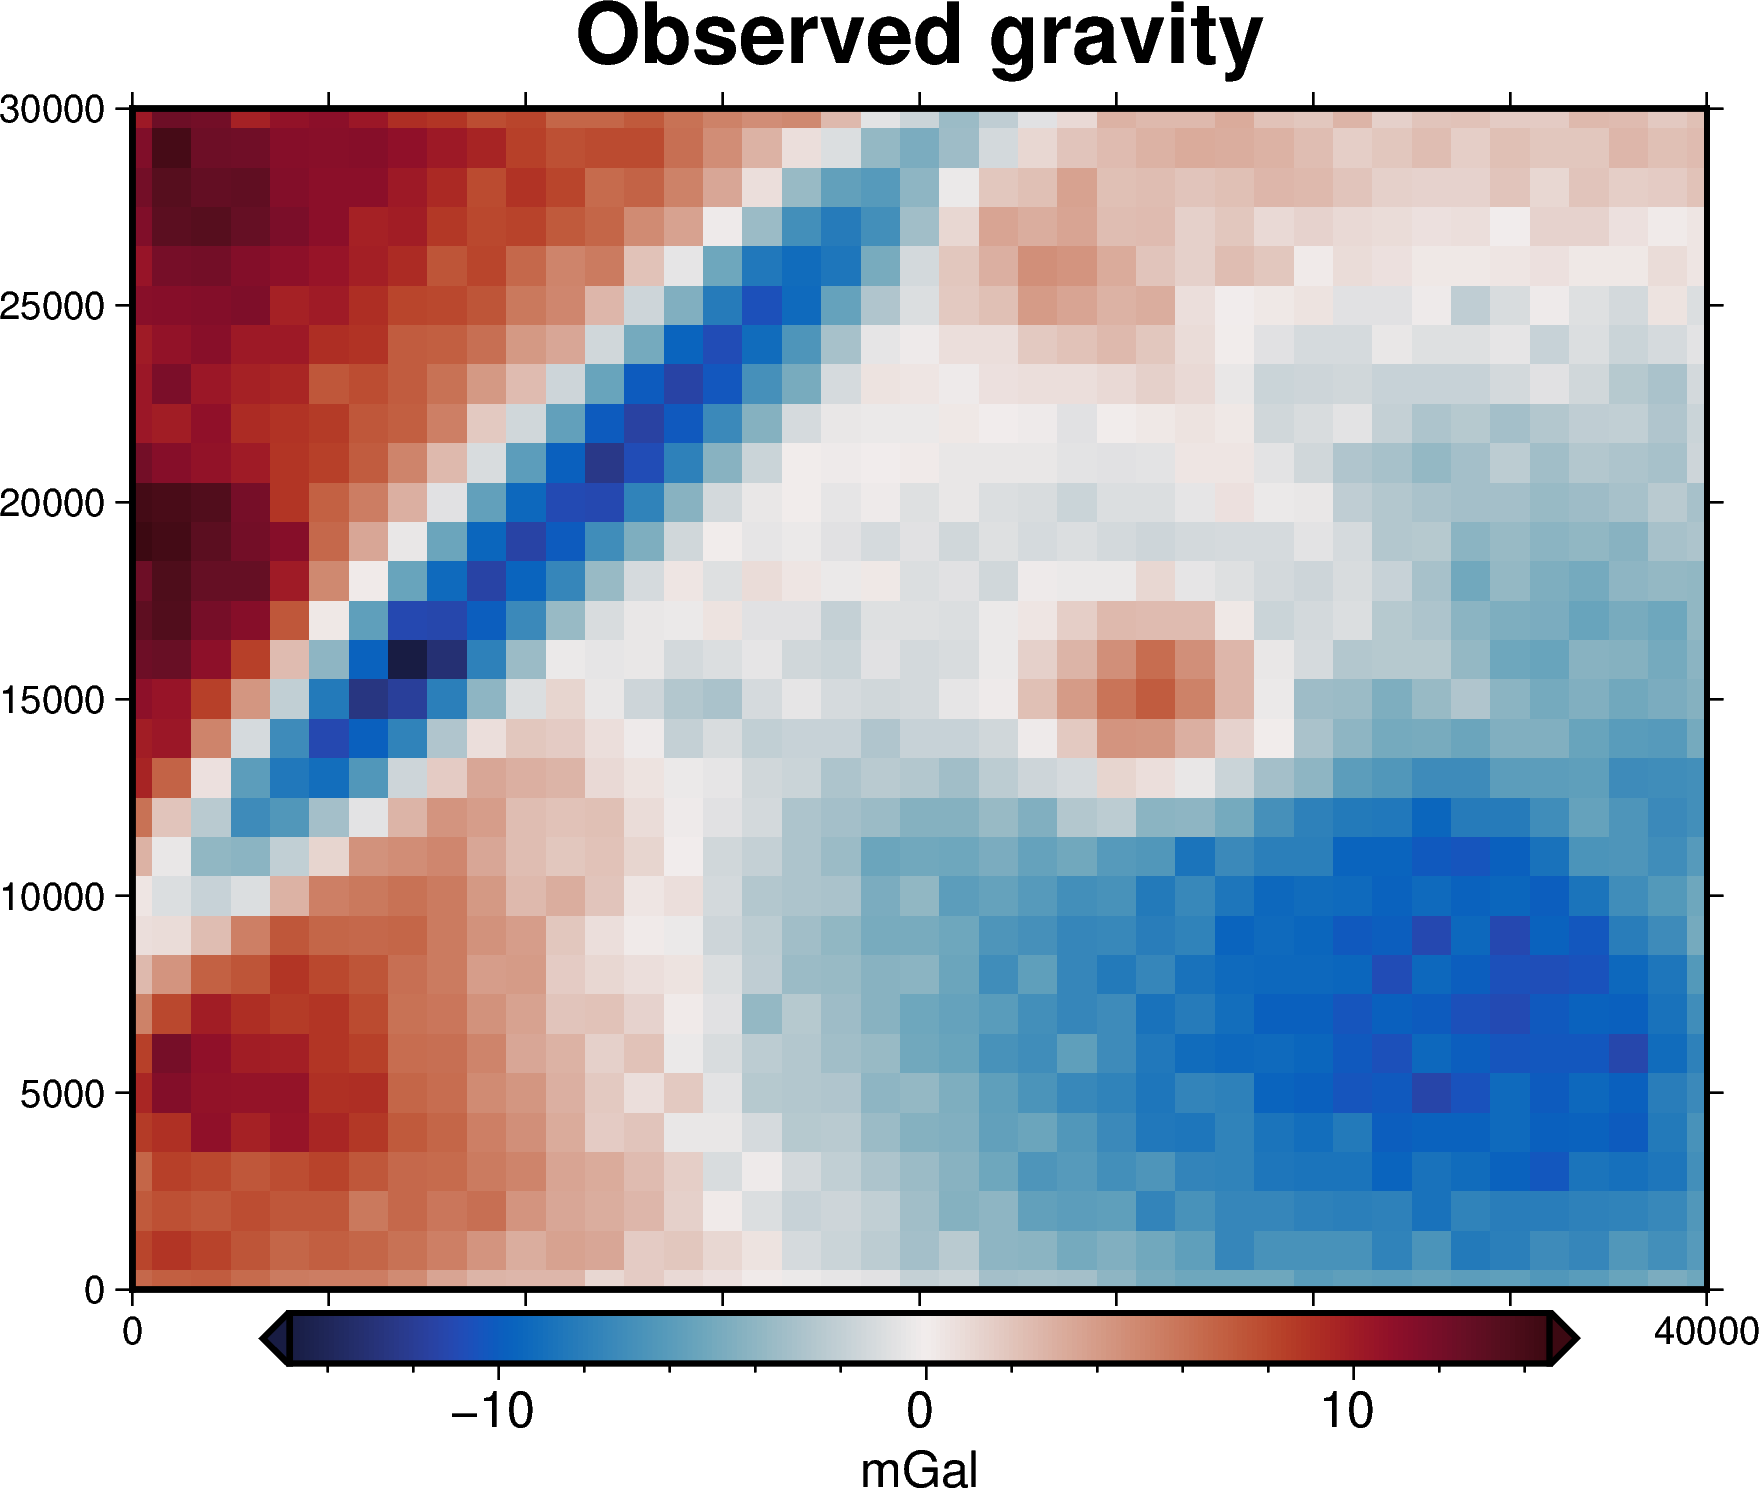

In [6]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

# plot the observed gravity
fig = maps.plot_grd(
    grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav,
    fig_height=10,
    title="Observed gravity",
    cmap="balance+h0",
    grd2_cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

## Gravity misfit
Now we need to create a starting model of the topography to start the inversion with. Since here we have no knowledge of either the topography or the appropriate reference level (`zref`), the starting model is flat, and therefore it's forward gravity is 0. If you had a non-flat starting model, you would need to calculate it's forward gravity effect, and subtract it from our observed gravity to get a starting gravity misfit. 

In this simple case, we assume that we know the true density contrast and appropriate reference value for the topography (`zref`), and use these values to create our flat starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

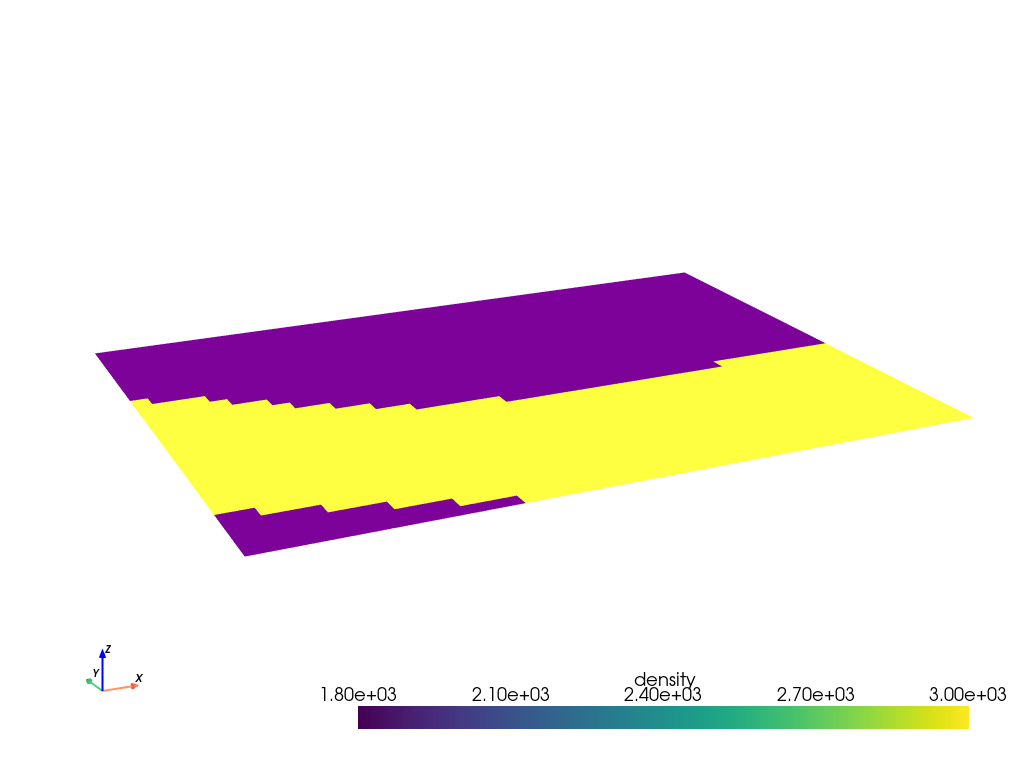

In [8]:
# create flat topography grid with a constant height
starting_topography = xr.full_like(true_topography, zref)

# prisms are created between zref and the height of the topography, which for this
# starting model is flat.
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(starting_topography >= zref, density_dist, -density_dist)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

In [9]:
# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["observed_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

,northing,easting,upward,grav,observed_grav,misfit,reg,res
0,0.0,0.0,1000.0,6.474723,6.557791,6.557791,0,6.557791
1,0.0,1000.0,1000.0,7.084438,7.038588,7.038588,0,7.038588
2,0.0,2000.0,1000.0,6.777225,7.117639,7.117639,0,7.117639
3,0.0,3000.0,1000.0,6.330090,6.402743,6.402743,0,6.402743
4,0.0,4000.0,1000.0,5.845346,5.597714,5.597714,0,5.597714
...,...,...,...,...,...,...,...,...
1266,30000.0,36000.0,1000.0,2.240245,1.701753,1.701753,0,1.701753
1267,30000.0,37000.0,1000.0,2.238745,2.591884,2.591884,0,2.591884
1268,30000.0,38000.0,1000.0,2.242352,2.408781,2.408781,0,2.408781
1269,30000.0,39000.0,1000.0,2.219123,1.766470,1.766470,0,1.766470


## Perform inversion
Now that we have a starting model and residual gravity misfit data we can start the inversion.

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0


Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

INFO:root:
 #################################### 
 iteration 1
INFO:root:Layer correction median: -3.7811 m, RMSE:27.4811 m
INFO:root:updated misfit RMSE: 3.776
INFO:root:updated L2-norm: 1.9432, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2745, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: 11.0236 m, RMSE:15.7339 m
INFO:root:updated misfit RMSE: 2.6046
INFO:root:updated L2-norm: 1.6139, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.2041, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 6.2749 m, RMSE:10.0917 m
INFO:root:updated misfit RMSE: 1.9412
INFO:root:updated L2-norm: 1.3933, tolerance: 0.5
INFO:root:updated delta L2-norm : 1.1583, tolerance: 1.005
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: 3.525 m, RMSE:7.0795 m
INFO:root:updated misfit RMSE: 1.5163
INFO:root:updated L2-norm: 1.2

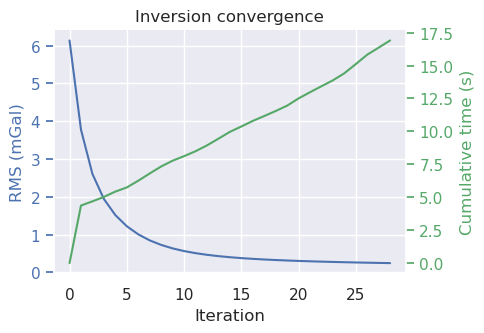

In [10]:
# set Python's logging level to get information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# run the inversion
results = inversion.run_inversion(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    prism_layer=starting_prisms,
    zref=zref,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    deriv_type="annulus",
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.5,
    delta_l2_norm_tolerance=1.005,
    #  display the convergence of the inversion
    plot_convergence=True,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

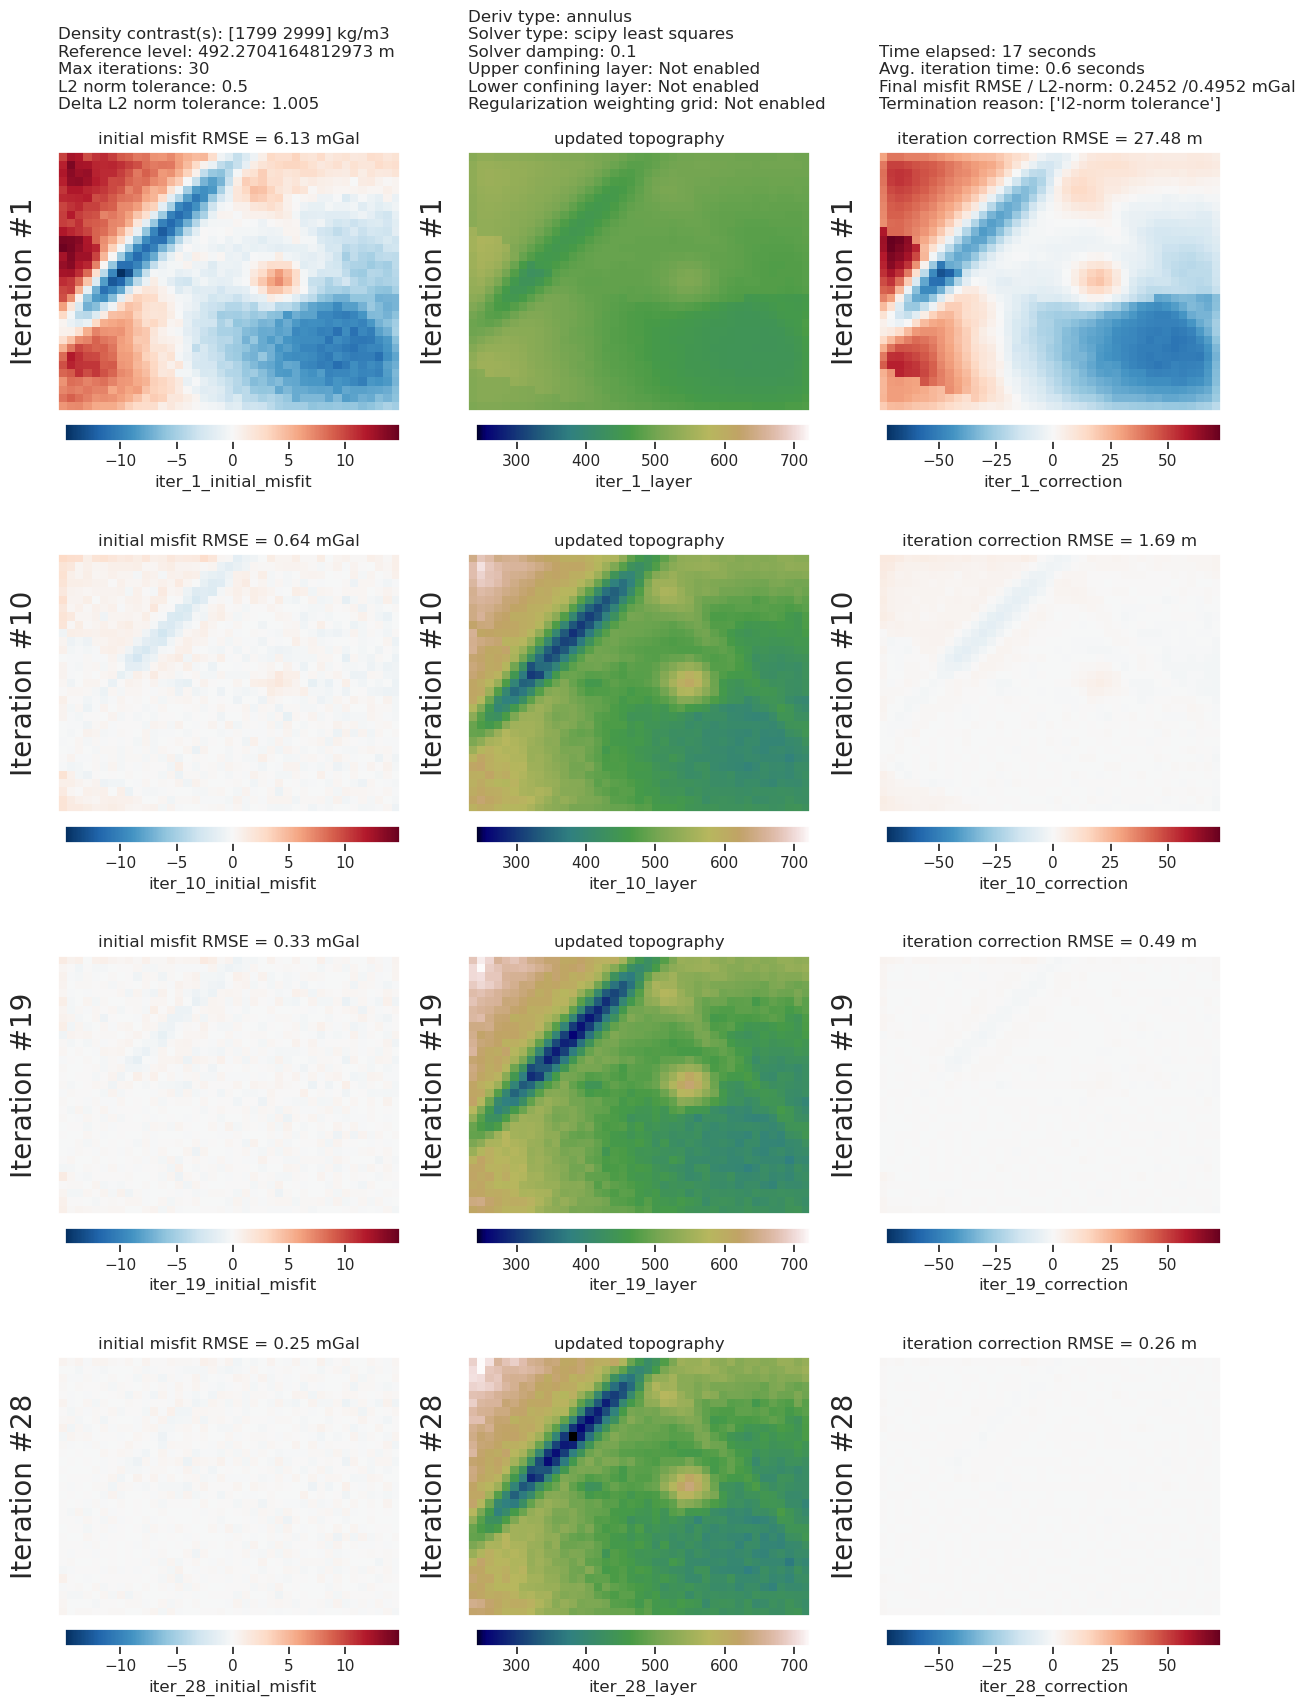

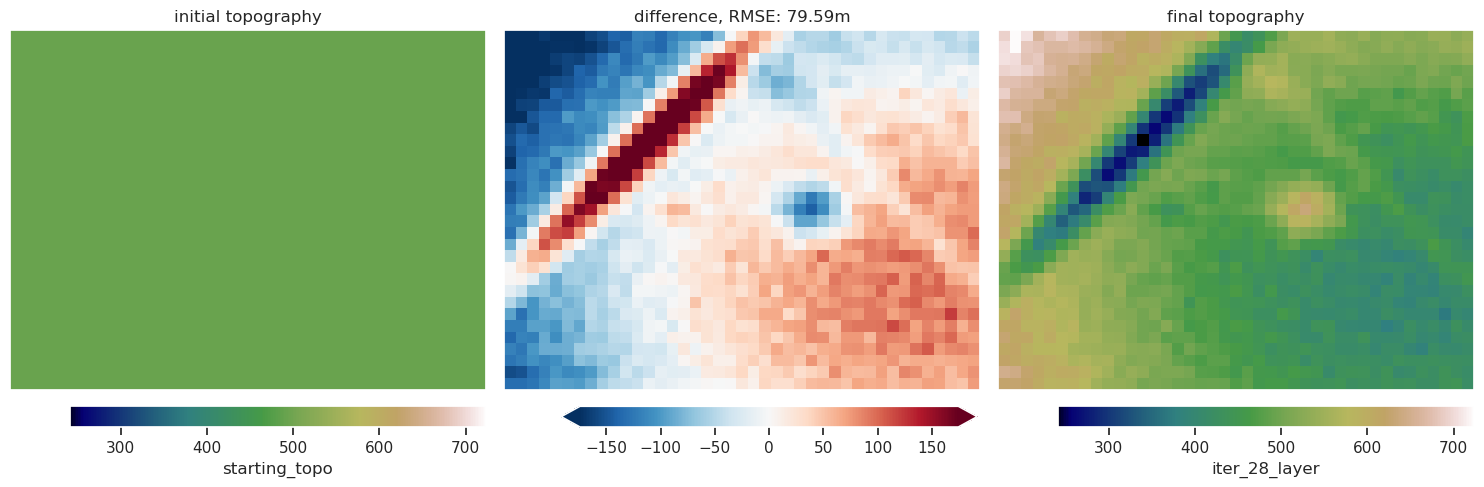

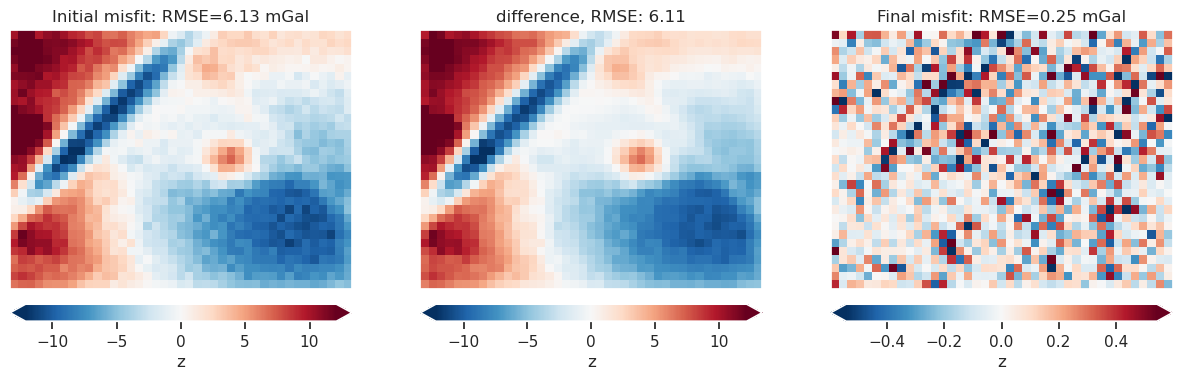

In [11]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

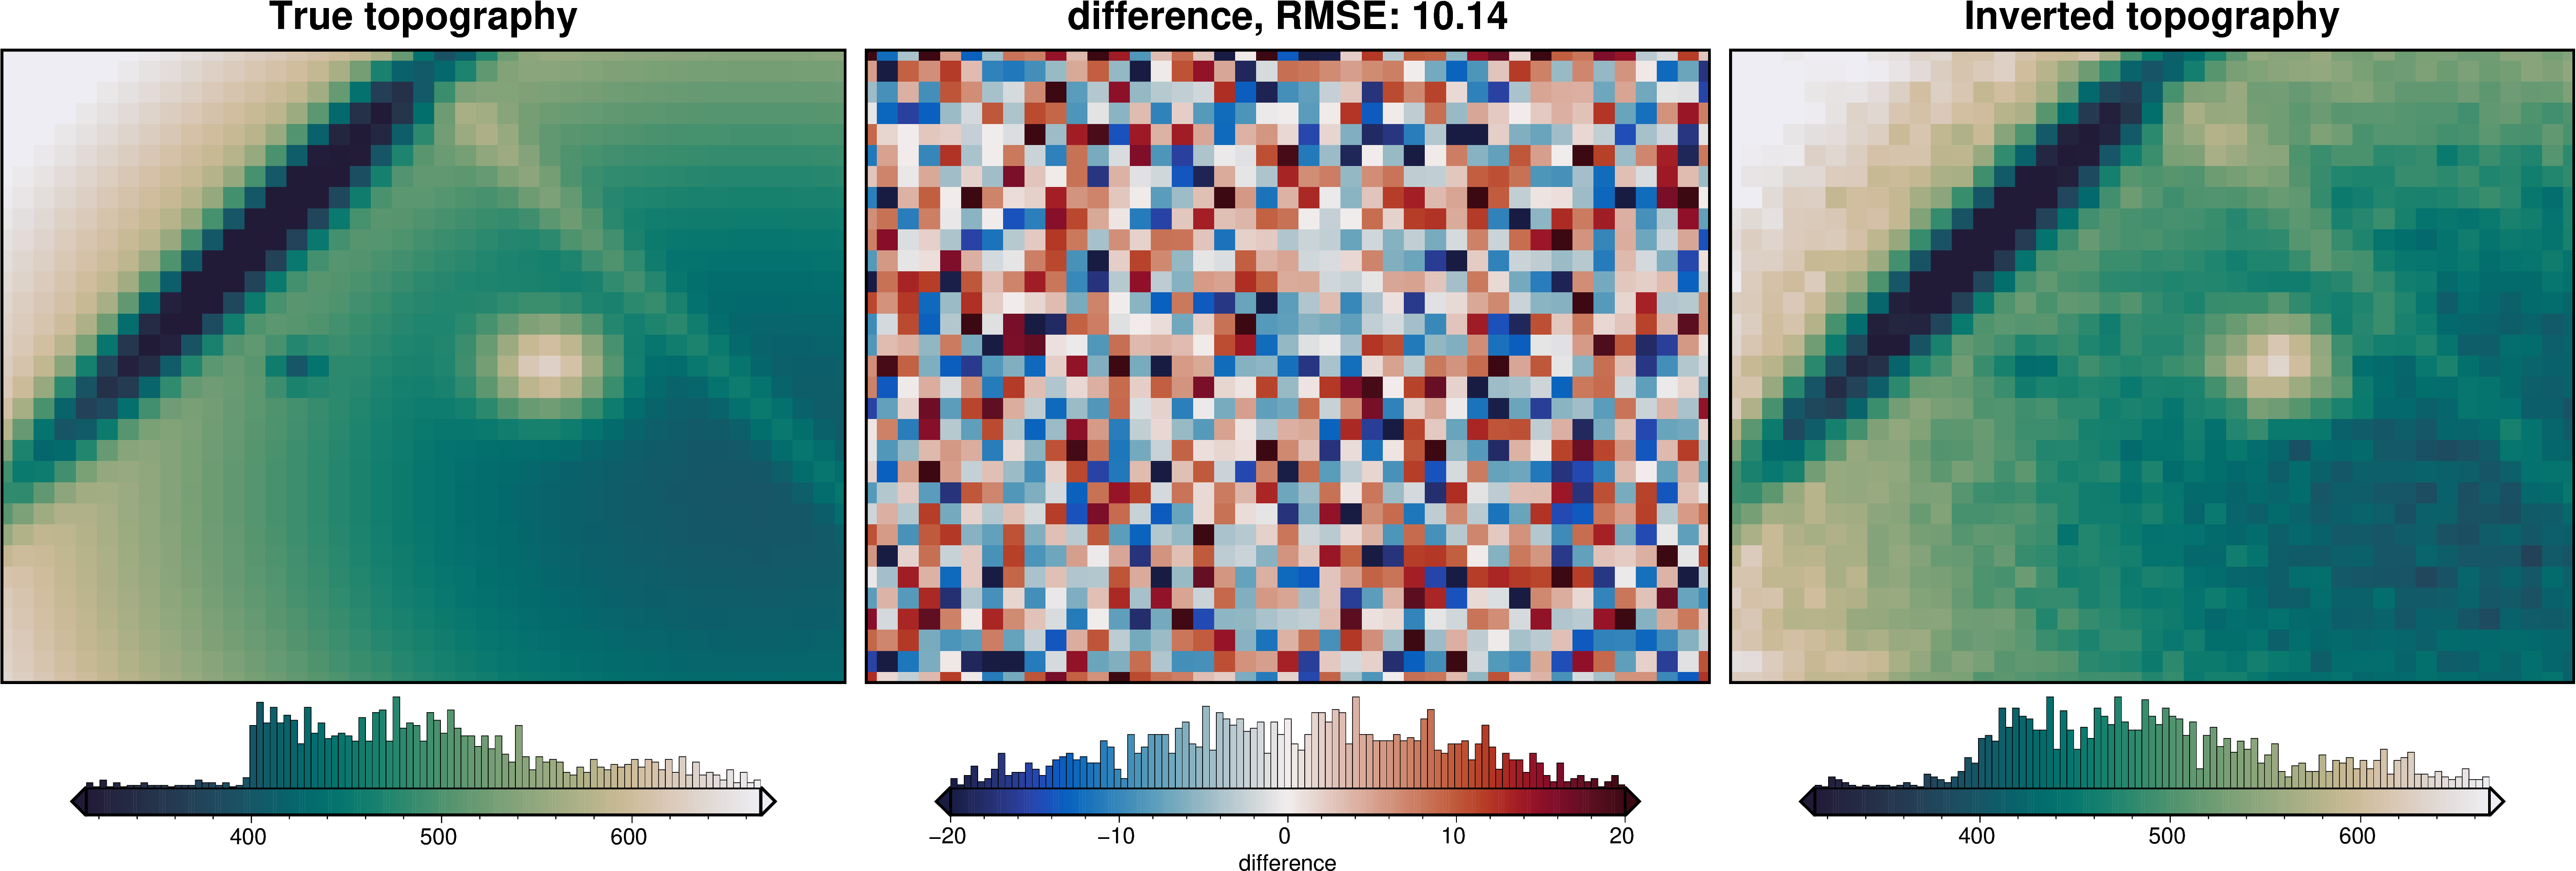

In [12]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    diff_lims=(-20, 20),
)